Based on: https://www.samsonzhang.com/2020/11/24/understanding-the-math-behind-neural-networks-by-building-one-from-scratch-no-tf-keras-just-numpy

In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt

def load_data():
    # with open('samples/t10k-images.idx3-ubyte','rb') as f:
    with open('samples/train-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, -1))
        data=data/255
    # with open('samples/t10k-labels.idx1-ubyte','rb') as f:
    with open('samples/train-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = labels.reshape((size,)) # (Optional)
    return labels, data, nrows, ncols

def load_validation_data():
    with open('samples/t10k-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        data = data.reshape((size, -1))
        data=data/255
    with open('samples/t10k-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = labels.reshape((size,)) # (Optional)
    return labels, data, nrows, ncols


In [2]:
def ReLU(Z):
    return np.maximum(Z,0)

def ReLU_dev(Z):
    return 1*(Z>0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1,b1,W2,b2,X):
    Z1=W1.dot(X)+b1
    A1=ReLU(Z1)
    Z2=W2.dot(A1)+b2
    A2=softmax(Z2)
    return Z1,A1,Z2,A2

def get_predictions(A2):
    return np.argmax(A2,axis=0)

In [3]:
def one_hot(y):
    yy=np.zeros((y.max()+1,y.size))
    yy[y,np.arange(y.size)]=1
    return yy

In [4]:
def cross_ent(y,y_hat): # true(onehotencoded), predicted
    return -np.log(y_hat.T[y.astype(bool).T])

In [5]:
def init_params():
    N_L1=100
    N_L2=10
    W1 = np.random.rand(N_L1, 784) - 0.5
    b1 = np.random.rand(N_L1, 1) - 0.5
    W2 = np.random.rand(N_L2, N_L1) - 0.5
    b2 = np.random.rand(N_L2, 1) - 0.5
    return W1, b1, W2, b2

In [6]:
# forward_prop(W1,b1,W2,b2,X):
# return Z1,A1,Z2,A2
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    N=Y.size
    one_hot_y=one_hot(Y)
    dZ2=A2-one_hot_y
    db2=np.sum(dZ2,axis=1,keepdims=True)/N
    dW2=dZ2.dot(A1.T)/N
    dZ1=W2.T.dot(dZ2)*ReLU_dev(Z1)
    db1=np.sum(dZ1,axis=1,keepdims=True)/N
    dW1=dZ1.dot(X.T)/N
    return dW1,db1,dW2,db2

In [7]:
def update_params(W1,b1, W2,b2,dW1,db1,dW2,db2,alpha):
    W1-=dW1*alpha
    b1-=db1*alpha
    W2-=dW2*alpha
    b2-=db2*alpha
    return W1, b1, W2, b2

In [8]:
def get_accuracy(predictions,Y):
    return np.sum(predictions==Y)/Y.size

In [149]:
def batch_split(x,batch_size,axis):
    b=batch_size
    x=x.swapaxes(0,axis)
    l=x.shape[0]
    n_b=range(l//b)
    for r in n_b:
        yield x[r*b:(r+1)*b].swapaxes(0,axis)
    if l%b>0:
        yield x[l//b*b:].swapaxes(0,axis)


In [154]:
def gradient_descent(X,Y,alpha,epochs,batch_size=100,X_v=None,Y_v=None):
    W1, b1, W2, b2 =init_params()
    N=Y.size
    debug=[]
    for i in range(epochs):
        # Shuffle trainig data first
        perms=np.random.permutation(N)
        X=X[:,perms]
        Y=Y[perms]
        c=0
        # Split in batches and run every batch each epoch. 
        for X_b,Y_b in zip(batch_split(X,batch_size,axis=1),batch_split(Y,batch_size,axis=0)):
            Z1,A1,Z2,A2 = forward_prop(W1,b1,W2,b2,X_b)
            dW1,db1,dW2,db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_b, Y_b)
            W1, b1, W2, b2 = update_params(W1,b1, W2,b2,dW1,db1,dW2,db2,alpha)

        if i%1==0 or i==epochs-1:
            _,_,_,A2 = forward_prop(W1,b1,W2,b2,X)
            predictions=get_predictions(A2)
            acc=get_accuracy(predictions,Y)
            acc_v=0
            if X_v is not None and Y_v is not None:
                _,_,_,A2_v = forward_prop(W1,b1,W2,b2,X_v)
                predictions_v=get_predictions(A2_v)
                acc_v=get_accuracy(predictions_v,Y_v)
            debug.append((i,acc,acc_v))
            print(f"Epoch: {i}\t\tAccuracy: {acc:.4f} \t\tAccuracy_v: {acc_v:.4f}")

    return W1,b1,W2,b2,debug

In [156]:
labels_train, data_train, nrows,ncols =load_data()
data_train=data_train.T
labels_validation, data_validation, _,_ =load_validation_data()
data_validation=data_validation.T
W1,b1,W2,b2,debug=gradient_descent(data_train,labels_train,0.5,100,batch_size=1000,X_v=data_validation,Y_v=labels_validation)

Epoch: 0		Accuracy: 0.8732 		Accuracy_v: 0.8766
Epoch: 1		Accuracy: 0.9038 		Accuracy_v: 0.9041
Epoch: 2		Accuracy: 0.9178 		Accuracy_v: 0.9153
Epoch: 3		Accuracy: 0.9251 		Accuracy_v: 0.9191
Epoch: 4		Accuracy: 0.9310 		Accuracy_v: 0.9274
Epoch: 5		Accuracy: 0.9370 		Accuracy_v: 0.9297
Epoch: 6		Accuracy: 0.9419 		Accuracy_v: 0.9350
Epoch: 7		Accuracy: 0.9449 		Accuracy_v: 0.9387
Epoch: 8		Accuracy: 0.9486 		Accuracy_v: 0.9404
Epoch: 9		Accuracy: 0.9510 		Accuracy_v: 0.9425
Epoch: 10		Accuracy: 0.9529 		Accuracy_v: 0.9461
Epoch: 11		Accuracy: 0.9563 		Accuracy_v: 0.9482
Epoch: 12		Accuracy: 0.9582 		Accuracy_v: 0.9502
Epoch: 13		Accuracy: 0.9598 		Accuracy_v: 0.9510
Epoch: 14		Accuracy: 0.9606 		Accuracy_v: 0.9523
Epoch: 15		Accuracy: 0.9625 		Accuracy_v: 0.9544
Epoch: 16		Accuracy: 0.9629 		Accuracy_v: 0.9524
Epoch: 17		Accuracy: 0.9652 		Accuracy_v: 0.9558
Epoch: 18		Accuracy: 0.9656 		Accuracy_v: 0.9557
Epoch: 19		Accuracy: 0.9674 		Accuracy_v: 0.9581
Epoch: 20		Accuracy: 0.9691 		

Final accuracy (Using training data):	 0.9955166666666667
Final accuracy (Using validation data):	 0.9706


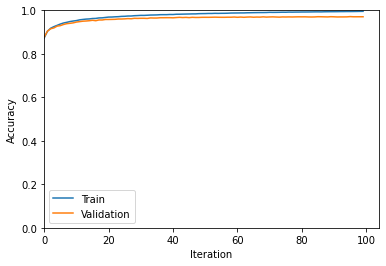

In [157]:
x,y1,y2=zip(*debug)
plt.plot(x,y1)
plt.plot(x,y2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
ax = plt.gca()
ax.set_xlim([0, None])
ax.set_ylim([0, 1])
print("Final accuracy (Using training data):\t",y1[-1])
print("Final accuracy (Using validation data):\t",y2[-1])
ax.legend(["Train","Validation"])
plt.show()

# Accuracy checks with training data

In [158]:
_,_,_,A2=forward_prop(W1,b1,W2,b2,data_train)
predictions_train=get_predictions(A2)
acc=get_accuracy(predictions_train,labels_train)

correct=labels_train==predictions_train

print("Accuracy: ",acc)
print("Mislabeled: ", np.sum(~correct))
print("ID\tLabel\tPrediction\tError")
for i,(lab,pred,right) in enumerate(zip(*(labels_train,predictions_train,correct))):
    if not right:
        print(f"{i}\t{lab}\t\t{pred}\t {'x' if not right else ''}")
        pass


Accuracy:  0.9955166666666667
Mislabeled:  269
ID	Label	Prediction	Error
132	5		3	 x
470	1		5	 x
500	3		2	 x
635	5		2	 x
788	9		0	 x
854	2		7	 x
1244	3		9	 x
1352	9		3	 x
1404	8		6	 x
1604	4		9	 x
1968	9		7	 x
2000	5		6	 x
2676	7		2	 x
2720	3		7	 x
2764	9		7	 x
2901	8		5	 x
3030	9		5	 x
3512	8		2	 x
3692	7		1	 x
4476	2		1	 x
5216	2		7	 x
5704	9		4	 x
5738	3		5	 x
5821	7		9	 x
5896	8		7	 x
6130	7		8	 x
6254	1		4	 x
6448	4		6	 x
6885	1		8	 x
7010	7		4	 x
7080	3		5	 x
7851	8		0	 x
7898	1		2	 x
7994	7		9	 x
8062	5		9	 x
8202	2		7	 x
8228	3		7	 x
8480	2		1	 x
8670	2		8	 x
8709	3		9	 x
8729	3		7	 x
8853	2		3	 x
8966	2		7	 x
9433	7		4	 x
9504	9		7	 x
9782	8		9	 x
10042	3		2	 x
10064	8		4	 x
10142	9		4	 x
10205	1		8	 x
10780	9		4	 x
10944	9		5	 x
10994	3		9	 x
11647	9		4	 x
11657	0		9	 x
11949	3		8	 x
12559	2		8	 x
12679	2		8	 x
13352	3		9	 x
13376	3		1	 x
13677	8		3	 x
13752	9		8	 x
13969	3		6	 x
14078	5		3	 x
15106	7		8	 x
15167	9		8	 x
15434	2		4	 x
15610	8		1	 x
15616	8		3	 x
15728	9		4	 x

Label: 4	Prediction: 7


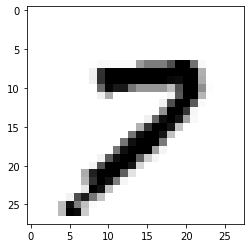

In [162]:
n=59915	
plt.imshow(data_train[:,n].reshape(nrows,ncols), cmap='gray_r')
print(f"Label: {labels_train[n]}\tPrediction: {predictions_train[n]}")
plt.show()

# Accuracy checks with validation data

In [163]:
_,_,_,A2=forward_prop(W1,b1,W2,b2,data_validation)
predictions_validation=get_predictions(A2)
acc=get_accuracy(predictions_validation,labels_validation)

correct=labels_validation==predictions_validation

print("Accuracy: ",acc)
print("Mislabeled: ", np.sum(~correct))
print("ID\tLabel\tPrediction\tError")
for i,(lab,pred,right) in enumerate(zip(*(labels_validation,predictions_validation,correct))):
    if not right:
        print(f"{i}\t{lab}\t\t{pred}\t {'x' if not right else ''}")
        pass


Accuracy:  0.9706
Mislabeled:  294
ID	Label	Prediction	Error
8	5		6	 x
126	0		9	 x
156	6		4	 x
247	4		6	 x
321	2		7	 x
340	5		3	 x
445	6		0	 x
447	4		9	 x
449	3		5	 x
479	9		5	 x
495	8		2	 x
543	8		5	 x
582	8		2	 x
583	2		7	 x
610	4		2	 x
613	2		8	 x
619	1		8	 x
646	2		6	 x
658	7		0	 x
684	7		3	 x
691	8		4	 x
717	0		6	 x
786	6		5	 x
813	9		8	 x
882	9		7	 x
938	3		5	 x
947	8		9	 x
951	5		7	 x
956	1		3	 x
965	6		0	 x
1014	6		5	 x
1039	7		2	 x
1072	3		5	 x
1107	9		5	 x
1112	4		6	 x
1138	2		1	 x
1181	6		1	 x
1192	9		4	 x
1224	2		4	 x
1226	7		2	 x
1232	9		4	 x
1242	4		9	 x
1247	9		5	 x
1289	5		9	 x
1299	5		7	 x
1319	8		3	 x
1325	8		6	 x
1364	8		6	 x
1378	5		6	 x
1414	9		4	 x
1441	8		2	 x
1444	6		7	 x
1464	8		3	 x
1494	7		8	 x
1496	7		9	 x
1500	7		1	 x
1522	7		9	 x
1530	8		7	 x
1549	4		6	 x
1553	9		3	 x
1569	6		4	 x
1597	9		8	 x
1609	2		3	 x
1621	0		6	 x
1681	3		7	 x
1709	9		5	 x
1712	0		9	 x
1716	7		9	 x
1754	7		2	 x
1790	2		8	 x
1850	8		3	 x
1901	9		4	 x
1903	7		3	 x
1940	5		8	 x
1952	9		8

Label: 5	Prediction: 6


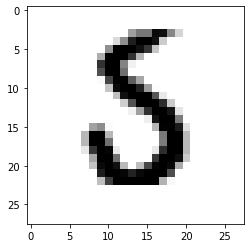

In [166]:
n=9941
plt.imshow(data_validation[:,n].reshape(nrows,ncols), cmap='gray_r')
print(f"Label: {labels_validation[n]}\tPrediction: {predictions_validation[n]}")
plt.show()

-------------------